**实验目标：**

通过本实验，你将深入了解和实践说话人识别技术，并掌握利用声音特征进行有效说话人识别的基本方法，了解不同特征和模型对识别准确率的影响。

实验的核心目标是使用TIMIT数据集来训练一个说话人识别系统，涵盖数据预处理、特征提取、模型训练和评估等关键步骤。


**实验方法：**

**1. 数据预处理和划分(可选)：**
  - 数据集下载地址：https://f.ws59.cn/f/du8yd2536vl
  - 为了方便大家，我们提供了划分好的TIMIT数据集结构，当然你也可以根据需求自行划分该数据集。
  - 为简化难度，我们排除了SA的两个方言句子，并在剩余的8个句子中选取了SX的5个句子和SI的1个句子作为训练集，SI的另外2个句子作为测试集。
  - 该链接下载的数据集只保留了音频文件，完整数据集（包含音频对应文本、标注等信息）可参见备注链接下载。
  
**2. 特征提取：**
  - 学习并实现包括但不限于MFCC特征等特征的提取，探索声音信号的频率和时间特性。
  - 鼓励尝试和比较其他特征提取方法，例如LPCC或声谱图特征，以理解不同特征对识别性能的影响。
  
**3. 模型选择和训练：**
  - 探索并选择适合的分类器和模型进行说话人识别，如GMM、Softmax分类器或深度学习模型。
  - 实现模型训练流程，使用训练集数据训练模型。
  
**4. 评估和分析：**
  - 使用准确率作为主要的评价指标在测试集上评估模型性能。
  - 对比不同特征和模型的性能，分析其对说话人识别准确率的影响。
  - 可视化不同模型的识别结果和错误率，讨论可能的改进方法。

**实验要求：**
  - 1.选择并实现至少一种特征的提取，并鼓励尝试其他特征提取方法。
  - 2.选择并实现至少一种分类器或模型进行说话人识别，并使用准确率评估指标评估其性能。
  - 3.通过实验对比、分析和可视化，撰写详细的实验报告，包括实验目的、实验方法、结果分析和结论。
  - 4.实验报告应以清晰、逻辑性强的形式呈现，图表和结果应清楚明了。

**其他说明：**
  - 实验的最终打分环节会看识别性能，会对原理和实现代码部分做抽查提问，综合评定成绩。
  - 我们**鼓励做原创性探索**，即使性能不是很好，但有创新性、有价值、有意义的探索和尝试会有额外加分。
  - 原数完整据集下载地址：https://drive.google.com/file/d/180mSIiXN9RVDV2Xn1xcWNkMRm5J5MjN4/view?usp=sharing \
    或国内访问地址（4月17日前有效）：https://f.ws59.cn/f/du8xu130kba

## 一、 实验准备

In [2]:
## 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import wave
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.linear_model import LogisticRegression


# 可以根据需要导入其他库，比如librosa用于音频处理

## 二、 数据预处理(加载数据集)

In [3]:
## 请从如下地址下载数据集（4月17日前有效）：https://f.ws59.cn/f/du8yd2536vl
# 数据集基本信息如下
# 方言地区：DR1～DR8
# 性别：F/M
# 说话者ID：3大写字母+1阿拉伯数字
# 句子ID：句子类型（SA/SI/SX）+编号
# 详细介绍参见 https://blog.csdn.net/qq_39373179/article/details/103788208

# 上述链接下载的数据集已经
TrainDir = "Dataset\TRAIN"
TestDir = "Dataset\TEST"
# 请在这里写代码加载我们划分好的TIMIT训练集和测试集。或者原始完整版数据集。

def load_data(data_dir):
    data=[] #文件地址
    area_labels=[] #区域
    sex_labels=[] #性别
    name_labels=[] #姓名
    labels=[]
    for area_dir in os.listdir(data_dir):
        area_path=os.path.join(data_dir, area_dir) #area_path:Dataset\TRAIN\DR1
        if os.path.isdir(area_path):
            for name_path in os.listdir(area_path): 
                file_path = os.path.join(area_path, name_path) #file_path:Dataset\TRAIN\DR1\FCJF0
                for path_name in os.listdir(file_path):
                    area_labels.append(area_dir)
                    sex_labels.append(name_path[0])
                    name_labels.append(name_path[1:])
                    path = os.path.join(file_path, path_name)
                    data.append(path)
    labels = [area_label + sex_label for area_label, sex_label in zip(area_labels, sex_labels)]
    print(data)
    print(name_labels)
    return data, name_labels
    
# 加载训练集和测试集
train_data, train_labels = load_data(TrainDir)
test_data, test_labels = load_data(TestDir)

print("")
print("训练集样本数量：", len(train_data))
print("测试集样本数量：", len(test_data))

['Dataset\\TRAIN\\DR1\\FCJF0\\merge_result.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SI648_.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SX127_.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SX217_.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SX307_.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SX37_.wav', 'Dataset\\TRAIN\\DR1\\FCJF0\\SX397_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\merge_result.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SI2036_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SX146_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SX236_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SX326_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SX416_.wav', 'Dataset\\TRAIN\\DR1\\FDAW0\\SX56_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\merge_result.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SI2075_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SX159_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SX249_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SX339_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SX429_.wav', 'Dataset\\TRAIN\\DR1\\FDML0\\SX69_.wav', 'Dataset\\TRAIN\\DR1\\FECD0\\merge_result.wav', 'Dataset\\TRAIN\\DR1\\FECD0\\SI788_.wav', 'Dataset\\

## 三、 特征提取
### 1.1 mfcc(取平均值，得到一维向量)

In [4]:
## 提取MFCC音频特征
def extract_mfcc_features(dataset):
    mfcc_features_list=[]
    for data in dataset:
        # 读取音频文件
        audio, sr = librosa.load(data) #audio:加载的音频数据;sr:音频的采样率
        # 提取MFCC特征
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sr,n_mfcc=30)
        mfcc_features = np.mean(mfcc_features,axis=1)
        mfcc_features_list.append(mfcc_features)
    return mfcc_features_list

print("训练集数据进行MFCC特征提取...")
train_mfcc_0 = extract_mfcc_features(train_data)
print("训练集MFCC特征:", len(train_mfcc_0),train_mfcc_0[0].shape)

print("测试集数据进行MFCC特征提取...")
test_mfcc_0 = extract_mfcc_features(test_data)
print("测试集MFCC特征:", len(test_mfcc_0),test_mfcc_0[0].shape)

训练集数据进行MFCC特征提取...
训练集MFCC特征: 3234 (30,)
测试集数据进行MFCC特征提取...
测试集MFCC特征: 924 (30,)


### 1.2 mfcc(进行对齐)

In [5]:
## 提取MFCC音频特征
def extract_mfcc_features(dataset):
    mfcc_features_list=[]
    for data in dataset:
        # 读取音频文件
        audio, sr = librosa.load(data) #audio:加载的音频数据;sr:音频的采样率
        # 提取MFCC特征
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sr,n_mfcc=40)
        mfcc_features_list.append(mfcc_features)
    return mfcc_features_list

def pad_or_truncate_mfcc(mfcc, target_length):
    # 确定当前MFCC序列的长度
    current_length = mfcc.shape[1]
    if current_length < target_length:
        # 如果当前序列长度小于目标长度，则在第二维上填充0
        padding = ((0, 0), (0, target_length - current_length))
        padded_mfcc = np.pad(mfcc, padding, mode='constant', constant_values=0)
        return padded_mfcc
    elif current_length > target_length:
        # 如果当前序列长度大于目标长度，则在第二维上截断
        truncated_mfcc = mfcc[:, :target_length]
        return truncated_mfcc
    else:
        # 如果当前序列长度等于目标长度，则直接返回
        return mfcc

target_length=200

print("训练集数据进行MFCC特征提取...")
train_mfcc = extract_mfcc_features(train_data)
# 对MFCC特征进行填充或截断
train_mfcc = [pad_or_truncate_mfcc(mfcc, target_length) for mfcc in train_mfcc]
print("训练集MFCC特征:", len(train_mfcc),train_mfcc[0].shape)

print("测试集数据进行MFCC特征提取...")
test_mfcc = extract_mfcc_features(test_data)
# 对MFCC特征进行填充或截断
test_mfcc = [pad_or_truncate_mfcc(mfcc, target_length) for mfcc in test_mfcc]
print("测试集MFCC特征:", len(test_mfcc),test_mfcc[0].shape)


训练集数据进行MFCC特征提取...
训练集MFCC特征: 3234 (40, 200)
测试集数据进行MFCC特征提取...
测试集MFCC特征: 924 (40, 200)


### 1.3 mfcc自行实现

In [6]:
def mfcc(filename):
    # 读取音频信号
    f = wave.open(filename,'rb')
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    '''
    nchannels: 声道数
    sampwidth: 量化位数
    framerate: 采样频率
    nframes: 采样点数
    '''
    str_data = f.readframes(nframes)
    signal = np.fromstring(str_data, dtype=np.short)
    signal = signal * 1.0 / (max(abs(signal)))# 归一化
    signal_len = len(signal)
    # 预加重
    signal_add = np.append(signal[0], signal[1:] - 0.97 * signal[:-1])
    time = np.arange(0,nframes) / 1.0 * framerate
    # 分帧、加窗
    wlen = 512
    inc = 128
    N = 512
    if signal_len < wlen:
        nf = 1
    else:
        nf = int(np.ceil((1.0 * signal_len - wlen + inc) / inc))
    pad_len = int((nf - 1) * inc + wlen)
    zeros = np.zeros(pad_len - signal_len)
    pad_signal = np.concatenate((signal, zeros))
    indices = np.tile(np.arange(0, wlen), (nf, 1)) + np.tile(np.arange(0, nf * inc, inc),(wlen, 1)).T
    indices = np.array(indices, dtype=np.int32)
    frames = pad_signal[indices]
    win = np.hanning(wlen)

    m = 24
    s = np.zeros((nf, m))
    for i in range(nf):
        x = frames[i:i + 1]
        y = win * x[0]
        a = np.fft.fft(y)# 快速傅里叶变换
        b = np.square(abs(a))# 计算能量谱线
        #  梅尔滤波器
        mel_high = 1125 * np.log(1 + (framerate / 2) / 700)
        mel_point = np.linspace(0, mel_high, m + 2)
        Fp = 700 * (np.exp(mel_point / 1125) - 1)
        w = int(N / 2 + 1)
        df = framerate / N
        fr = []
        for n in range(w):
            frs = int(n * df)
            fr.append(frs)
        melbank = np.zeros((m, w))
        for k in range(m + 1):
            f1 = Fp[k - 1]
            f2 = Fp[k + 1]
            f0 = Fp[k]
            n1 = np.floor(f1 / df)
            n2 = np.floor(f2 / df)
            n0 = np.floor(f0 / df)
            for j in range(w):
                if j >= n1 and j <= n0:
                    melbank[k - 1, j] = (j - n1) / (n0 - n1)
                if j >= n0 and j <= n2:
                    melbank[k - 1, j] = (n2 - j) / (n2 - n0)
            for c in range(w):
                s[i, k - 1] = s[i, k - 1] + b[c:c + 1] * melbank[k - 1, c]
            # plt.plot(fr, melbank[k - 1,])
    # plt.show()
    logs = np.log(s)# 取对数
    num_ceps = 12
    D = dct(logs, type=2, axis=0, norm='ortho')[:, 1:(num_ceps + 1)]
    # print(D)
    # print(filename, np.shape(D))
    return D

### 2. spectrogram

In [7]:
#提取声谱图音频特征
def extract_spectrogram_features(dataset):
    spectrogram_features_list = []
    for data in dataset:
        # 读取音频文件
        audio, sr= librosa.load(data)
        # 提取声谱图特征
        spectrogram = np.abs(librosa.stft(y=audio))
        spectrogram=np.mean(spectrogram, axis=1)
        spectrogram_features_list.append(spectrogram)
    return  spectrogram_features_list

train_spectrogram = extract_spectrogram_features(train_data)
print("训练集声谱图特征:", len(train_spectrogram), train_spectrogram[0].shape)

test_spectrogram = extract_spectrogram_features(test_data)
print("测试集声谱图特征:", len(test_spectrogram), test_spectrogram[0].shape)

训练集声谱图特征: 3234 (1025,)
测试集声谱图特征: 924 (1025,)


### 3. lpc+lsp

In [8]:
def extract_lpc_lsp_features(dataset, order=12):
    lpc_features_list = []
    lsp_features_list = []
    for data in dataset:
        # 读取音频文件
        audio, sr = librosa.load(data)
        # 提取LPC系数
        lpc = librosa.lpc(audio, order=order)
        lpc_features_list.append(lpc)
        # 提取lsp特征
        lsp = np.roots(lpc)
        lsp_features_list.append(lsp)
    return lpc_features_list,lsp_features_list


train_lpc,train_lsp = extract_lpc_lsp_features(train_data, order=12)
print("训练集LPC特征:", len(train_lpc), train_lpc[0].shape)
print("训练集LSP特征:", len(train_lsp), train_lsp[0].shape)

test_lpc,test_lsp = extract_lpc_lsp_features(test_data, order=12)
print("测试集LPC特征:", len(test_lpc), test_lpc[0].shape)
print("测试集LSP特征:", len(test_lsp), test_lsp[0].shape)



训练集LPC特征: 3234 (13,)
训练集LSP特征: 3234 (12,)
测试集LPC特征: 924 (13,)
测试集LSP特征: 924 (12,)


## 4. 模型选择和训练、评价指标（准确率Accuracy）

### 1.GMM模型

**实验目的：**
 - GMM是一种概率模型，用于表示存在子群体的数据集的概率分布，这些子群体通常是正态分布的。实验中，我们训练了多个GMM，每个GMM对应一个类别，并用这些模型对测试数据进行分类。

**实验方法：**
 - 实验过程分为两个主要部分：模型训练和预测评估。

**1、模型训练：**
 - 使用train_models函数，我们为数据集中的每个唯一标签（类别）训练了一个GMM。
 - 函数接受训练数据train_datas和对应的标签train_labels，以及GMM的参数设置，如n_components（高斯分布的数量），max_iter（最大迭代次数），和reg_covar（正则化协方差）。
 - 对于每个类别，我们收集该类别的所有特征，然后训练一个GMM。
 - 训练完成后，每个模型被存储在一个字典models中，以便于之后的预测。
 
**2、预测评估：**
 - 使用predict函数，我们对测试数据集test_datas进行分类预测。
 - 对于每个测试样本，我们计算其在每个GMM上的得分（概率对数），并选择得分最高的标签作为预测标签。
 - 预测完成后，我们使用accuracy_score来计算模型的准确率，即正确预测的数量与总预测数量的比例。

**实验分析：**

 - 参数选择：n_components参数的选择对模型性能有显著影响。太少的组件可能无法捕捉数据的复杂性，而太多的组件可能导致过拟合。
 - 正则化：reg_covar参数添加到协方差矩阵中以提高数值稳定性，这对于避免奇异协方差矩阵和确保模型训练的顺利进行至关重要。
 - 迭代次数：max_iter参数决定了模型训练的迭代次数，如果太少可能导致模型未能收敛，而太多则可能导致不必要的计算开销。

### 1.1 GMM+mfcc

In [9]:
def train_models(train_datas, train_labels, n_components=1, max_iter=10,reg_covar=2):
    #n_components: 这是GMM中高斯分布的数量,max_iter: 最大的迭代次数,covariance_type='diag': 这表示每个组件的协方差矩阵类型。
    #reg_covar是一个正则化参数，它是一个正数，它将被添加到每个组件的协方差矩阵中，以确保这些协方差矩阵在计算中保持稳定。
    
    models = {}
    unique_labels = np.unique(train_labels)
    
    for label in unique_labels:
        # 收集当前类别的所有特征
        label_features = [feature for feature, current_label in zip(train_datas, train_labels) if current_label == label]
        # 训练一个GMM模型
        gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, covariance_type='full',random_state=0,reg_covar=reg_covar)
        gmm.fit(np.vstack(label_features))
        # 存储模型
        models[label] = gmm
        
    return models

# 训练GMM模型
try:
    gmm_models_mfcc = train_models(train_mfcc_0, train_labels)
    print("完成模型训练!")
except Exception as e:
    print("训练失败:", e)


完成模型训练!


In [10]:
def predict(test_datas, models):
    predictions = []
    for data in test_datas:
        best_label, best_score = None, float('-inf')
        for label, model in models.items():
            #使用GMM模型的 score 方法来计算特征向量的得分（概率对数)
            score = model.score(np.atleast_2d(data))
            if score > best_score:
                best_label, best_score = label, score
        predictions.append(best_label)
        #在循环结束后，将最高得分对应的标签添加到 predictions 列表中
    return predictions

# 进行预测
print("正在进行预测...")
test_predictions_mfcc = predict(test_mfcc_0, gmm_models_mfcc)
print("预测完成!")

# 计算准确率
accuracy_gmm_mfcc = accuracy_score(test_labels, test_predictions_mfcc)
print(f"准确率: {accuracy_gmm_mfcc:.2f}")



正在进行预测...
预测完成!
准确率: 0.54


### 1.2 GMM+spectrogram  (麻烦徐彬芮调一下)

In [11]:
def train_models(train_datas, train_labels, n_components=1, max_iter=10,reg_covar=2):
    #n_components: 这是GMM中高斯分布的数量,max_iter: 最大的迭代次数,covariance_type='diag': 这表示每个组件的协方差矩阵类型。
    #reg_covar是一个正则化参数，它是一个正数，它将被添加到每个组件的协方差矩阵中，以确保这些协方差矩阵在计算中保持稳定。
    
    models = {}
    unique_labels = np.unique(train_labels)
    
    for label in unique_labels:
        # 收集当前类别的所有特征
        label_features = [feature for feature, current_label in zip(train_datas, train_labels) if current_label == label]
        # 训练一个GMM模型
        gmm = GaussianMixture(n_components=n_components, max_iter=max_iter, covariance_type='full',random_state=0,reg_covar=reg_covar)
        gmm.fit(np.vstack(label_features))
        # 存储模型
        models[label] = gmm
        
    return models

# 训练GMM模型
try:
    gmm_models_spectrogram = train_models(train_spectrogram, train_labels)
    print("完成模型训练!")
except Exception as e:
    print("训练失败:", e)

# 进行预测
print("正在进行预测...")
test_predictions_spectrogram = predict(test_spectrogram, gmm_models_spectrogram)
print("预测完成!")

# 计算准确率
accuracy_gmm_spectrogram = accuracy_score(test_labels, test_predictions_spectrogram)
print(f"准确率: {accuracy_gmm_spectrogram:.2f}")


完成模型训练!
正在进行预测...
预测完成!
准确率: 0.15


### 2.全连接网络
**实验目的：**
 - 本实验的目的是构建一个全连接神经网络（FCNN），用于处理音频数据集中的特征，并在此基础上进行说话人识别。实验利用PyTorch框架，通过GPU加速计算，并在训练集上训练模型，在测试集上评估模型性能。

**实验方法：**
 - 实验过程分为数据预处理、模型构建、模型训练和性能评估四个主要部分。

**1、数据预处理：**
 - 将标签转换为整数索引，并将数据和标签转换为PyTorch张量。
 - 将数据和标签移动到GPU上以加速计算（如果可用）。
 - 使用DataLoader创建可迭代的数据集，方便批量处理。

**2、模型构建：**
 - 构建一个简单的全连接神经网络，包括批量归一化层、线性层和ReLU激活函数。
 - 模型的输入维度是MFCC特征的维度，输出维度是说话人的数量。

**3、模型训练：**
 - 在多个epoch内循环数据集，使用Adam优化器和交叉熵损失函数进行训练。
 - 每个epoch结束时输出损失值，以监控训练过程。

**4、性能评估：**
 - 在训练集和测试集上分别评估模型，计算准确率作为性能指标。

**实验分析：**
 - 模型性能：通过比较训练集和测试集上的准确率，我们可以评估模型的拟合程度和泛化能力。如果训练集准确率远高于测试集，可能存在过拟合的情况。
 - 训练过程：损失值的下降趋势反映了模型学习的进展。如果损失值停止下降，可能意味着模型已经收敛或需要调整学习率。
 - 模型结构：FCNN模型的简单结构可能限制了其处理复杂特征的能力。在未来的工作中，可以考虑添加更多的隐藏层或使用不同的激活函数来提高模型的表现。

### 2.1 全连接网络+mfcc

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 创建一个从标签到整数索引的映射字典
label_to_index = {label: idx for idx, label in enumerate(set(train_labels))}
print(label_to_index)  # 打印映射关系，以供检查
# 使用映射将所有标签转换为整数索引
train_labels_integers = [label_to_index[label] for label in train_labels]
test_labels_integers = [label_to_index[label] for label in test_labels]

#数据预处理
features_tensor_train=torch.tensor(train_mfcc_0,dtype=torch.float32)
features_tensor_test=torch.tensor(test_mfcc_0,dtype=torch.float32)
labels_tensor_train=torch.tensor(train_labels_integers,dtype=torch.long)
labels_tensor_test=torch.tensor(test_labels_integers,dtype=torch.long)

#cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
features_tensor_train=features_tensor_train.to(device)
labels_tensor_train=labels_tensor_train.to(device)
features_tensor_test=features_tensor_test.to(device)
labels_tensor_test=labels_tensor_test.to(device)

#dataloader
train_dataset=TensorDataset(features_tensor_train,labels_tensor_train)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataset=TensorDataset(features_tensor_test,labels_tensor_test)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

#全连接网络
class FCNN_MFCC(nn.Module):
    def __init__(self,input_dim,num_speaker):
        super(FCNN_MFCC,self).__init__()
        self.bn1=nn.BatchNorm1d(input_dim)
        self.fc1=nn.Linear(input_dim,256)
        self.bn2=nn.BatchNorm1d(256)
        self.fc2=nn.Linear(256,num_speaker)
    def forward(self,x):
        x=self.bn1(x)
        x=F.relu(self.fc1(x))
        x=self.bn2(x)
        x=self.fc2(x)
        return x

# 训练模型
def train(num_epochs,dataloader,optimizer,criterion,model):
    for epoch in range(num_epochs):
        model.train()
        for features, labels in dataloader:
            features, labels = features.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() 
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

#测试模型性能
def test(model,dataloader):
    model.eval()
    with torch.no_grad():
        # 用于存储正确预测的数量
        correct = 0
        total = 0
        
        # 遍历测试集
        for features, labels in dataloader:
            features, labels = features.cuda(), labels.cuda()
            # 预测
            outputs = model(features)
            # 计算最大值的索引，即模型预测的类别
            _, predicted = torch.max(outputs, 1)
            # 将标签和预测转换为numpy数组以进行比较
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 计算准确率
        accuracy = correct / total
        print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')
    return accuracy

input_dim=30
num_speakers=len(np.unique(train_labels))
model = FCNN_MFCC(input_dim, num_speakers).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
    
model=train(100,train_loader,optimizer,criterion,model)
print('在训练集上的表现')
accuracy_train=test(model,train_loader)
print('在测试集上的表现')
accuracy_FCNN_mfcc=test(model,test_loader)

{'CAJ0': 0, 'CDR0': 1, 'STF0': 2, 'LET0': 3, 'CDC0': 4, 'KES0': 5, 'SDJ0': 6, 'JSP0': 7, 'LJA0': 8, 'HJB0': 9, 'LAC0': 10, 'JMD0': 11, 'MLM0': 12, 'JEB0': 13, 'JRG0': 14, 'CLM0': 15, 'DJH0': 16, 'SDB0': 17, 'HXL0': 18, 'KKH0': 19, 'RRE0': 20, 'RCW0': 21, 'PRD0': 22, 'JJM0': 23, 'LTM0': 24, 'CDD0': 25, 'KFB0': 26, 'REH0': 27, 'WGR0': 28, 'JEE0': 29, 'MSM0': 30, 'JXM0': 31, 'HIT0': 32, 'TER0': 33, 'APB0': 34, 'CEW0': 35, 'KLC0': 36, 'SAG0': 37, 'DBB1': 38, 'JRA0': 39, 'ALR0': 40, 'DBP0': 41, 'PFU0': 42, 'HRM0': 43, 'RGM0': 44, 'HLM0': 45, 'RXB0': 46, 'TPP0': 47, 'SPM0': 48, 'PLS0': 49, 'TRT0': 50, 'PRT0': 51, 'SMA0': 52, 'ABC0': 53, 'EAC0': 54, 'FXV0': 55, 'WAC0': 56, 'CTH0': 57, 'SDS0': 58, 'DNC0': 59, 'RDS0': 60, 'RFK0': 61, 'JKR0': 62, 'JSK0': 63, 'BMA0': 64, 'MGK0': 65, 'JXP0': 66, 'KAH0': 67, 'REE0': 68, 'JXA0': 69, 'ARW0': 70, 'LBC0': 71, 'RAM0': 72, 'DML0': 73, 'EJS0': 74, 'DPS0': 75, 'BEF0': 76, 'MVP0': 77, 'RDD0': 78, 'JLG0': 79, 'SKC0': 80, 'RHL0': 81, 'SFH0': 82, 'MAH1': 83, '

c:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  from ipykernel import kernelapp as app


Epoch [1/100], Loss: 4.5180
Epoch [2/100], Loss: 3.0695
Epoch [3/100], Loss: 1.7557
Epoch [4/100], Loss: 1.4047
Epoch [5/100], Loss: 0.7837
Epoch [6/100], Loss: 0.4184
Epoch [7/100], Loss: 0.3000
Epoch [8/100], Loss: 0.3836
Epoch [9/100], Loss: 0.1507
Epoch [10/100], Loss: 0.2453
Epoch [11/100], Loss: 0.1548
Epoch [12/100], Loss: 0.0831
Epoch [13/100], Loss: 0.0823
Epoch [14/100], Loss: 0.0559
Epoch [15/100], Loss: 0.1248
Epoch [16/100], Loss: 0.0552
Epoch [17/100], Loss: 0.1291
Epoch [18/100], Loss: 0.0886
Epoch [19/100], Loss: 0.0518
Epoch [20/100], Loss: 0.0310
Epoch [21/100], Loss: 0.0362
Epoch [22/100], Loss: 0.0877
Epoch [23/100], Loss: 0.0377
Epoch [24/100], Loss: 0.0304
Epoch [25/100], Loss: 0.0437
Epoch [26/100], Loss: 0.0124
Epoch [27/100], Loss: 0.0243
Epoch [28/100], Loss: 0.0184
Epoch [29/100], Loss: 0.0243
Epoch [30/100], Loss: 0.0164
Epoch [31/100], Loss: 0.0245
Epoch [32/100], Loss: 0.0204
Epoch [33/100], Loss: 0.0318
Epoch [34/100], Loss: 0.0134
Epoch [35/100], Loss: 0

### 2.2 全连接网络+spectrogram

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#数据预处理
features_tensor_train=torch.tensor(train_spectrogram,dtype=torch.float32)
features_tensor_test=torch.tensor(test_spectrogram,dtype=torch.float32)

#cuda
features_tensor_train=features_tensor_train.to(device)
labels_tensor_train=labels_tensor_train.to(device)
features_tensor_test=features_tensor_test.to(device)
labels_tensor_test=labels_tensor_test.to(device)

#dataloader
train_dataset=TensorDataset(features_tensor_train,labels_tensor_train)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataset=TensorDataset(features_tensor_test,labels_tensor_test)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

#全连接网络
class FCNN_Spectrogram(nn.Module):
    def __init__(self,input_dim,num_speaker):
        super(FCNN_Spectrogram,self).__init__()
        self.bn1=nn.BatchNorm1d(input_dim)
        self.fc1=nn.Linear(input_dim,256)
        self.bn2=nn.BatchNorm1d(256)
        self.fc2=nn.Linear(256,num_speaker)
    def forward(self,x):
        x=self.bn1(x)
        x=F.relu(self.fc1(x))
        x=self.bn2(x)
        x=self.fc2(x)
        return x

input_dim=1025

model = FCNN_Spectrogram(input_dim, num_speakers).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
model=train(100,train_loader,optimizer,criterion,model)
print('在训练集上的表现')
accuracy_train=test(model,train_loader)
print('在测试集上的表现')
accuracy_FCNN_spectrogram=test(model,test_loader)

Epoch [1/100], Loss: 5.1501
Epoch [2/100], Loss: 3.8815
Epoch [3/100], Loss: 2.5160
Epoch [4/100], Loss: 1.6645
Epoch [5/100], Loss: 1.2193
Epoch [6/100], Loss: 0.7480
Epoch [7/100], Loss: 0.6637
Epoch [8/100], Loss: 0.5309
Epoch [9/100], Loss: 0.3205
Epoch [10/100], Loss: 0.2119
Epoch [11/100], Loss: 0.1817
Epoch [12/100], Loss: 0.1272
Epoch [13/100], Loss: 0.0869
Epoch [14/100], Loss: 0.1375
Epoch [15/100], Loss: 0.1084
Epoch [16/100], Loss: 0.0625
Epoch [17/100], Loss: 0.0654
Epoch [18/100], Loss: 0.0497
Epoch [19/100], Loss: 0.0467
Epoch [20/100], Loss: 0.0546
Epoch [21/100], Loss: 0.0307
Epoch [22/100], Loss: 0.0259
Epoch [23/100], Loss: 0.0330
Epoch [24/100], Loss: 0.0224
Epoch [25/100], Loss: 0.0404
Epoch [26/100], Loss: 0.0455
Epoch [27/100], Loss: 0.0348
Epoch [28/100], Loss: 0.0141
Epoch [29/100], Loss: 0.0545
Epoch [30/100], Loss: 0.0580
Epoch [31/100], Loss: 0.0143
Epoch [32/100], Loss: 0.1285
Epoch [33/100], Loss: 0.0494
Epoch [34/100], Loss: 0.0881
Epoch [35/100], Loss: 0

**实验结果分析：**

**1、频谱图特征的全连接网络结果：**
 - 训练过程：从损失函数随着epoch的递减可以看出，模型在训练集上学习效果良好，损失从初始的5.1501降到了0.0404，这表明模型在训练过程中逐渐拟合数据。
 - 训练集准确率：模型在训练集上达到了99.51%的准确率。
 - 测试集准确率：模型在测试集上的准确率为70.89%，相较于训练集有显著下降。这可能表明模型在训练数据上存在过拟合，泛化能力有待提高。
 
**2、MFCC特征的全连接网络结果：**
 - 训练过程：损失值从初始值下降，这表明模型在训练过程中逐渐拟合数据。
 - 训练集准确率：模型在训练集上的准确率为100.00%，这表明模型完美拟合了训练数据。
 - 测试集准确率：模型在测试集上的准确率为84.96%，比使用频谱图特征的模型高。
 
**结论：**
- 两种特征提取方法都能够让全连接网络在训练集上获得高准确率，但在测试集上的表现有所下降。MFCC特征的网络在测试集上表现更好，这可能是因为MFCC特征在音频分类任务中更能捕捉到区分不同类别的关键信息。

### 3. 自注意力机制

**实验目的**
 - 探究自注意力机制（特别是Transformer结构）对于音频分类任务的有效性。我们使用了Mel频率倒谱系数（MFCC）作为音频特征，并构建了一个基于Transformer的神经网络分类器来识别不同的说话者。

**实验方法**

**1、数据预处理**
 - 在实验中，我们首先将音频数据转换为MFCC特征，这些特征能够捕捉到音频信号中的关键信息。然后，我们将这些MFCC特征转换为适用于神经网络模型的格式。具体来说，我们使用了PyTorch的TensorDataset和DataLoader来构建适合模型训练的数据加载器。

**2、模型结构**
- 我们设计了一个基于Transformer的分类器模型，它包含以下几个部分：
 - 前置网络（Prenet）：一个线性层，将输入的MFCC特征维度映射到模型的内部维度。
 - Transformer编码器：由Transformer编码器层组成，负责捕捉序列内的依赖关系。
 - 预测层（Prediction Layer）：由线性层和Dropout组成，负责将编码后的特征映射到最终的类别上。
 
**3、训练过程**
- 模型使用Adam优化器进行训练，损失函数为交叉熵损失。训练过程中，我们监控了训练损失，并在训练结束后评估了模型在训练集和测试集上的准确性。




### 3.1 自注意力机制+mfcc

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#数据预处理
features_tensor_train=torch.tensor(train_mfcc,dtype=torch.float32)
features_tensor_test=torch.tensor(test_mfcc,dtype=torch.float32)

features_tensor_train=features_tensor_train.to(device)
features_tensor_test=features_tensor_test.to(device)

train_dataset=TensorDataset(features_tensor_train,labels_tensor_train)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_dataset=TensorDataset(features_tensor_test,labels_tensor_test)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

class Classifier(nn.Module):
  def __init__(self, input_dim=40,d_model=80, n_spks=num_speakers, num_heads=2,dropout=0.5):
    super().__init__()

    self.prenet = nn.Linear(input_dim, d_model)
    self.encoder_layer = nn.TransformerEncoderLayer(
      d_model=d_model, 
      dim_feedforward=256, 
      nhead=num_heads
    )
    self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    self.pred_layer = nn.Sequential(
      nn.Linear(d_model, d_model),
      nn.Dropout(dropout),
      nn.Linear(d_model, n_spks),
    )

  def forward(self, x):
    x= x.permute(0, 2, 1)
    # out: (batch size, length, d_model)
    out = self.prenet(x)
    # out: (length, batch size, d_model)
    out = out.permute(1, 0, 2)
    # The encoder layer expect features in the shape of (length, batch size, d_model).
    out = self.encoder(out)
    # out: (batch size, length, d_model)
    out = out.transpose(0, 1)
    # mean pooling
    stats = out.mean(dim=1)
    # out: (batch, n_spks)
    out = self.pred_layer(stats)
    return out


net = Classifier().to(device) 

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Create a model instance
train(150,train_loader,optimizer,criterion,net)
print('在训练集上的表现')
accuracy_train=test(net,train_loader)
print('在测试集上的表现')
accuracy_selfattention_mfcc=test(net,test_loader)
    

Epoch [1/150], Loss: 6.2020
Epoch [2/150], Loss: 6.2217
Epoch [3/150], Loss: 6.1563
Epoch [4/150], Loss: 6.1026
Epoch [5/150], Loss: 5.8461
Epoch [6/150], Loss: 5.6774
Epoch [7/150], Loss: 5.3545
Epoch [8/150], Loss: 5.4746
Epoch [9/150], Loss: 5.1326
Epoch [10/150], Loss: 4.7676
Epoch [11/150], Loss: 4.3276
Epoch [12/150], Loss: 4.3256
Epoch [13/150], Loss: 3.7538
Epoch [14/150], Loss: 3.5879
Epoch [15/150], Loss: 2.9963
Epoch [16/150], Loss: 2.8512
Epoch [17/150], Loss: 2.7220
Epoch [18/150], Loss: 2.2933
Epoch [19/150], Loss: 2.3778
Epoch [20/150], Loss: 2.2786
Epoch [21/150], Loss: 1.8225
Epoch [22/150], Loss: 1.5179
Epoch [23/150], Loss: 1.4187
Epoch [24/150], Loss: 1.8762
Epoch [25/150], Loss: 1.4535
Epoch [26/150], Loss: 1.6406
Epoch [27/150], Loss: 1.2553
Epoch [28/150], Loss: 0.8346
Epoch [29/150], Loss: 1.2468
Epoch [30/150], Loss: 1.1240
Epoch [31/150], Loss: 0.9968
Epoch [32/150], Loss: 0.6008
Epoch [33/150], Loss: 1.1076
Epoch [34/150], Loss: 0.8427
Epoch [35/150], Loss: 0

**实验结果分析：**

经过150个训练周期后，模型在训练集上达到了99.78%的准确率，在测试集上达到了75.00%的准确率。从训练损失的下降趋势可以看出，模型能够从数据中学习并逐渐提高其预测能力。

**结论：**

实验结果表明，基于Transformer的模型能够有效地处理音频分类任务，并且在训练集上取得了很高的准确率。然而，模型在测试集上的表现比训练集差，这可能表明模型过拟合了训练数据。

### 4.1 逻辑回归+mfcc
![示例图片](http://picture.gptkong.com/20240509/0017c6de8d93f2465881ffba082ca27e5e.png)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#标准化处理
scaler = StandardScaler()
train_mfcc_scaled = scaler.fit_transform(train_mfcc_0)
test_mfcc_scaled = scaler.transform(test_mfcc_0)

#初始化模型
LogisticRegression_classifier_mfcc = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#模型训练
LogisticRegression_classifier_mfcc.fit(train_mfcc_scaled , train_labels)
#预测
predictions_mfcc = LogisticRegression_classifier_mfcc.predict(test_mfcc_scaled)
#测试性能
accuracy_LogisticRegression_mfcc = accuracy_score(test_labels, predictions_mfcc)

print("准确率：", accuracy_LogisticRegression_mfcc)

c:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


准确率： 0.8387445887445888


### 4.2 逻辑回归+spectrogram
![示例图片](http://picture.gptkong.com/20240509/001957fb71b8f743b3aba471fb0f889021.png)

In [16]:
#标准化处理
scaler = StandardScaler()
train_spectrogram_scaled = scaler.fit_transform(train_spectrogram)
test_spectrogram_scaled = scaler.transform(test_spectrogram)

#初始化模型
LogisticRegression_classifier_spectrogram = LogisticRegression(multi_class='multinomial', solver='lbfgs')
#模型训练
LogisticRegression_classifier_spectrogram.fit(train_spectrogram_scaled , train_labels)
#预测
predictions_spectrogram = LogisticRegression_classifier_spectrogram.predict(test_spectrogram_scaled)
#测试性能
accuracy_LogisticRegression_spectrogram = accuracy_score(test_labels, predictions_spectrogram)

print("准确率：", accuracy_LogisticRegression_spectrogram)

c:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


准确率： 0.6363636363636364


**实验结果分析：**

**1、MFCC特征的性能：**
 - MFCC特征在逻辑回归模型上达到了83.87%的准确率，这是一个相对较高的结果，表明MFCC特征能够很好地捕捉音频数据的重要信息，并且适合用于逻辑回归模型的音频分类任务。
 - MFCC作为一种基于人类听觉感知的特征，能够有效地表示音频信号中对于分类任务重要的信息。

**2、频谱图特征的性能：**
- 频谱图特征在逻辑回归模型上得到了63.64%的准确率，相对于MFCC特征，这个结果较低。这可能表明频谱图特征在未经过进一步处理或特征选择的情况下，包含了一些对于逻辑回归模型来说不那么有用的信息。
- 频谱图提供了音频信号的全面频率分布信息，但同时也可能引入了噪声或不相关的信息，这些信息可能会对模型的性能产生负面影响。

**3、模型收敛问题：**
 - 在两种特征表示的实验中，都出现了模型未能收敛的警告。这可能是因为默认的迭代次数太少，无法达到收敛条件。

**结论：**

MFCC特征对于逻辑回归模型来说是一个更有效的音频特征表示，相比于频谱图，它能够在保持较高准确率的同时避免模型过于复杂。这强调了进行特征选择和特征工程的重要性，特别是在使用相对简单的模型时。

## accuracy_score自实现

In [17]:
#from sklearn.metrics import accuracy_score
def accuracy_score(y_true, y_pred):
    correct_predictions = 0
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            correct_predictions += 1
    accuracy = correct_predictions / len(y_true)
    return accuracy

In [18]:
#训练模型
LogisticRegression_classifier_lpc = LogisticRegression(multi_class='multinomial', solver='lbfgs')
LogisticRegression_classifier_lpc .fit(train_lpc, train_labels)
# 使用训练好的模型进行测试数据的预测
predictions_lpc = LogisticRegression_classifier_lpc .predict(test_lpc )
print(predictions_lpc)
# 计算准确率并评估模型性能
accuracy_lpc = accuracy_score(test_labels, predictions_lpc)
print("准确率：", accuracy_lpc)

c:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['DLR0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'DLR0' 'CEW0' 'TRC0' 'DLR0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'TRC0' 'CEW0' 'CEW0' 'TRC0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'ARW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'ARW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'ARW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'TRC0' 'CEW0' 'DLR0' 'CEW0' 'CEW0' 'DLR0' 'CEW0'
 'CEW0' 'ARW0' 'CEW0' 'CEW0' 'CEW0' 'ARW0' 'TRC0' 'CEW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'TRC0' 'TRC0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0'
 'CEW0' 'DLR0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0'
 'TRC0' 'CEW0' 'ARW0' 'CEW0' 'TRC0' 'CEW0' 'TRC0' 'CEW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'ARW0' 'DLR0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'DLR0' 'CEW0' 'CEW0'
 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'ARW0' 'CEW0' 'CEW0'
 'TRC0' 'TRC0' 'CEW0' 'CEW0' 'CEW0' 'CEW0' 'TRC0' 'TRC0' 'ARW0' 'CEW0'
 'CEW0

In [19]:
# 将复数特征转换为实数特征
train_lsp_adjusted = np.abs(train_lsp)
test_lsp_adjusted = np.abs(test_lsp)
#训练模型
LogisticRegression_classifier_lsp = LogisticRegression(multi_class='multinomial', solver='lbfgs')
LogisticRegression_classifier_lsp  .fit(train_lsp_adjusted , train_labels)
# 使用训练好的模型进行测试数据的预测
predictions_lsp = LogisticRegression_classifier_lsp .predict(test_lsp_adjusted )
print(predictions_lsp)
# 计算准确率并评估模型性能
accuracy_lsp  = accuracy_score(test_labels, predictions_lsp)
print("准确率：", accuracy_lsp)

c:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


['DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'REM0' 'DLR0' 'DLR0' 'REM0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'REM0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'KAJ0' 'DLR0' 'REM0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'JRB0' 'DLR0' 'DLR0' 'DLR0'
 'JRG0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'REM0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'REM0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0' 'DLR0'
 'DLR0

##  6. 分析和可视化

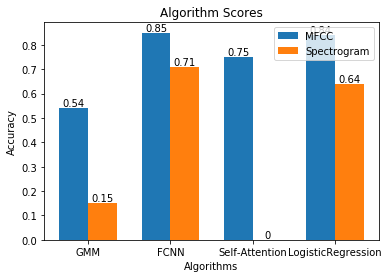

In [20]:
## 请使用matplotlib等可视化库对你的实验结果进行可视化分析。
## 包括但不限于准确率的对比、错误分类的分析、特征的影响等。
accuracy_selfattention_spectrogram=0

features = ['MFCC', 'Spectrogram']
scores = {'GMM':[round(accuracy_gmm_mfcc,2),round(accuracy_gmm_spectrogram,2)],
          'FCNN':[round(accuracy_FCNN_mfcc,2),round(accuracy_FCNN_spectrogram,2)],
          'Self-Attention':[round(accuracy_selfattention_mfcc,2),round(accuracy_selfattention_spectrogram,2)],
          'LogisticRegression':[round(accuracy_LogisticRegression_mfcc,2),round(accuracy_LogisticRegression_spectrogram,2)]}

# 提取算法名称和分数
algorithms = list(scores.keys())
mfcc_scores = [score[0] for score in scores.values()]
spectrogram_scores = [score[1] for score in scores.values()]

# 设置柱状图的位置和宽度
bar_width = 0.35
index = np.arange(len(algorithms))

# 绘制MFCC分数柱状图
plt.bar(index, mfcc_scores, bar_width, label='MFCC')
# 绘制Spectrogram分数柱状图
plt.bar(index + bar_width, spectrogram_scores, bar_width, label='Spectrogram')

# 在每个柱状图上添加数字标签
for i in range(len(algorithms)):
    plt.text(index[i], mfcc_scores[i], str(mfcc_scores[i]), ha='center', va='bottom')
    plt.text(index[i] + bar_width, spectrogram_scores[i], str(spectrogram_scores[i]), ha='center', va='bottom')

# 设置图表标题和标签
plt.title('Algorithm Scores')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')

# 设置x轴刻度标签
plt.xticks(index + bar_width/2, algorithms)

# 添加图例
plt.legend()

# 显示图表
plt.show()

## 7. 结果讨论
讨论你的模型性能，尝试解释为什么某些模型比其他模型表现好，以及可能的改进方法。
 - 由实验结果可以看出，FCNN和逻辑回归表现最好，自注意力模型次之。

**全连接神经网络（FCNN）：**
 - FCNN模型通常具有较高的表现性能，因为它们能够学习输入数据的非线性表示。FCNN模型的准确率最高，这可能表明数据集包含复杂的模式，这些模式可以通过FCNN模型中的多层非线性变换被有效捕捉。

**逻辑回归：**
 - 逻辑回归是一个线性模型，通常在数据可线性分离时表现良好。逻辑回归模型实验中表现出色，这可能意味着音频数据集中的类别可以通过线性边界相对容易地分离，或者特征表示（如MFCC）已经足够好，以至于使得分类问题变得较为简单。

**自注意力模型：**
 - 自注意力模型是基于Transformer架构的，它非常擅长捕捉序列数据中的长距离依赖关系。自注意力模型的准确率较高但不是最高的，可能是因为它在处理音频数据时确实捕捉到了有用的上下文信息，但由于某些原因（如模型配置、训练不足、数据不足等）未能完全发挥其潜力。
 - 另一个可能的原因是自注意力模型需要大量的数据来训练，如果数据集相对较小，它可能没有足够的数据来学习有效的表示。

**高斯混合模型（GMM）：**
 - GMM是一种概率模型，通常用于聚类分析，但也可以用于分类任务。GMM模型实验中表现不如其他模型，可能是因为它无法有效地建模数据中的复杂结构，或者因为特征空间不适合GMM来分离不同的类别。


## 8. 保存模型（可选）
如果需要，可以在这里添加代码保存你的模型。